### Sử dụng model Random forest và dự đoán trên tập test

In [583]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

#### 1. Bước chuẩn bị dữ liệu

In [584]:
with open("final_model_clustered/preprocessor_cat.pkl", "rb") as file:
    preprocessor_cat = pickle.load(file)

In [585]:
with open("final_model_clustered/preprocessor_num.pkl", "rb") as file:
    preprocessor_num = pickle.load(file)

In [586]:
with open("final_model_clustered/preprocessor_clustering.pkl", "rb") as file:
    preprocessor_clustering = pickle.load(file)

In [587]:
preprocessor_clustering.feature_names_in_

array(['Cluster', 'match_type'], dtype=object)

In [588]:
with open("final_model_clustered/RF.pkl", "rb") as file:
    RF_model = pickle.load(file)

In [589]:
with open("final_model_clustered/kmeans_model.pkl", "rb") as file:
    kmeans_model = pickle.load(file)

In [590]:
# Định nghĩa các hàm gán nhãn
def assign_cluster_label(cluster):
    if cluster == 0:
        return 'Strong Opponent'
    elif cluster == 1:
        return 'Average Opponent'
    elif cluster == 2:
        return 'Weak Opponent'
    else:
        return 'Unknown'

In [591]:
# Load dữ liệu từ tập test
test_df = pd.read_csv("../../../feature_engineering_data/test/arsenal.csv")
test_df["win_percent_diff"] = test_df['win_percent_before_team1'] - test_df['win_percent_before_team2']
test_df["ELO_before_diff"] = test_df['ELO_before_match_team1'] - test_df['ELO_before_match_team2']

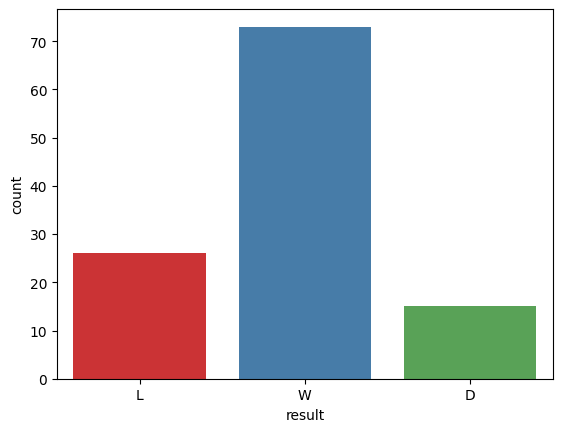

In [592]:
sns.countplot(x="result", data=test_df, palette="Set1");

In [593]:
test_df_with_opponent = test_df[
    [
        "opponent",
        "result",
        "venue",
        "season",
        "win_percent_before_team2",
        "win_percent_diff",
        "lose_percent_before_team2",
        "head2head_win_percent",
        "head2head_draw_percent",
        "head2head_lost_percent",
        "is_opponent_big6",
        "ELO_before_match_team2",
        "ELO_before_diff",
        "average_score_before_match_team2",
    ]
]

test_df = test_df[
    [
        "opponent",
        "result",
        "venue",
        "season",
        "win_percent_before_team2",
        "win_percent_diff",
        "lose_percent_before_team2",
        "head2head_win_percent",
        "head2head_draw_percent",
        "head2head_lost_percent",
        "is_opponent_big6",
        "ELO_before_match_team2",
        "ELO_before_diff",
        "average_score_before_match_team2",
    ]
]

In [594]:
test_df.head()

,opponent,result,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Brentford,L,Away,2021-2022,0.0,0.00,0.00,0.0,0.0,0.0,0,1500.000000,0.000000,0.00
1,Chelsea,L,Home,2021-2022,1.0,-1.00,0.00,0.4,0.3,0.3,1,1543.750000,-81.250000,3.00
2,Manchester City,L,Away,2021-2022,0.5,-0.50,0.50,0.0,0.1,0.9,1,1516.951881,-83.338715,1.50
3,Norwich City,W,Home,2021-2022,0.0,0.00,1.00,0.6,0.3,0.1,0,1380.465615,-8.621007,0.00
4,Burnley,W,Away,2021-2022,0.0,0.25,0.75,0.7,0.2,0.1,0,1372.877445,30.992418,0.25


In [595]:
test_df.columns

Index(['opponent', 'result', 'venue', 'season', 'win_percent_before_team2',
       'win_percent_diff', 'lose_percent_before_team2',
       'head2head_win_percent', 'head2head_draw_percent',
       'head2head_lost_percent', 'is_opponent_big6', 'ELO_before_match_team2',
       'ELO_before_diff', 'average_score_before_match_team2'],
      dtype='object')

##### Phân chia dữ liệu thành X, y

In [596]:
X_test = test_df.drop(["result","opponent"], axis=1)
y_test = test_df["result"]

In [597]:
X_test.head()

,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Away,2021-2022,0.0,0.00,0.00,0.0,0.0,0.0,0,1500.000000,0.000000,0.00
1,Home,2021-2022,1.0,-1.00,0.00,0.4,0.3,0.3,1,1543.750000,-81.250000,3.00
2,Away,2021-2022,0.5,-0.50,0.50,0.0,0.1,0.9,1,1516.951881,-83.338715,1.50
3,Home,2021-2022,0.0,0.00,1.00,0.6,0.3,0.1,0,1380.465615,-8.621007,0.00
4,Away,2021-2022,0.0,0.25,0.75,0.7,0.2,0.1,0,1372.877445,30.992418,0.25


#### 2. Chuẩn hoá, encoding dữ liệu

In [598]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_df["result"])

In [599]:
# D: 0
# L: 1
# W: 2
y_test

array([1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 1,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 2,
       2, 2, 2, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2,
       2, 2, 2, 2])

In [600]:
# # Áp dụng preprocessor đã lưu
# transformed_X = preprocessor_cat.transform(X_test)

# # Lấy tên các cột đã được chuyển đổi từ tất cả các thành phần của preprocessor
# venue_features = list(preprocessor_cat.named_transformers_["venue"].get_feature_names_out())
# season_features = list(preprocessor_cat.named_transformers_["season"].get_feature_names_out())

# # Xác định các cột phân loại và cột số
# categorical_cols = X_test.select_dtypes(include=['object', 'category']).columns
# numerical_cols = X_test.select_dtypes(include=['int32', 'int64', 'float64']).columns

# numerical_cols, categorical_cols

# # Gộp tất cả các tên cột lại
# columns = (
#     venue_features +
#     season_features +
#     numerical_cols.tolist()
# )

# # In ra để kiểm tra số lượng cột từ mỗi transformer và tổng số
# print(f"Number of 'venue' features: {len(venue_features)}")
# print(f"Number of 'season' features: {len(season_features)}")
# print(f"Number of numerical columns: {len(numerical_cols)}")
# print(f"Total number of columns expected: {len(columns)}")
# print(f"Actual number of features in transformed_X: {transformed_X.shape[1]}")

# # Kiểm tra xem có khớp với số lượng cột trong transformed_X không
# if len(columns) == transformed_X.shape[1]:
#     transformed_X = pd.DataFrame(transformed_X, columns=columns)
#     print(transformed_X.head())
# else:
#     print("Mismatch in the number of expected and actual features.")

In [601]:
# Xác định các cột phân loại và cột số
categorical_cols = X_test.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_test.select_dtypes(include=['int32', 'int64', 'float64']).columns
# Áp dụng các bộ xử lý đã lưu cho phần dữ liệu phân loại và số
transformed_cat = preprocessor_cat.transform(X_test[categorical_cols])
transformed_num = preprocessor_num.transform(X_test[numerical_cols])

# Lấy tên các cột đã được chuyển đổi từ tất cả các thành phần của preprocessor
venue_features = list(preprocessor_cat.named_transformers_["venue"].get_feature_names_out())
season_features = list(preprocessor_cat.named_transformers_["season"].get_feature_names_out())
# Giả định rằng preprocessor_num không thay đổi tên cột
numerical_features = numerical_cols.tolist()

# Gộp tất cả các tên cột lại
columns = venue_features + season_features + numerical_features

# Hợp nhất kết quả và tạo DataFrame mới
transformed_X = np.hstack([transformed_cat, transformed_num])
X_test = pd.DataFrame(transformed_X, columns=columns, index=X_test.index)

# In ra DataFrame để kiểm tra
X_test.head()
X_test.shape

(114, 17)

In [602]:
# Áp dụng mô hình phân cụm để dự đoán nhãn cụm cho dữ liệu kiểm thử
clusters = kmeans_model.predict(X_test)
X_test['Cluster'] = clusters
X_test['match_type'] = X_test['Cluster'].apply(assign_cluster_label)

In [603]:
X_test.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.912758,0.0,0.00,0.0,0.0,0.0,-0.500,0.033296,-0.442575,0.0,1,Average Opponent
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.212308,1.0,0.00,0.4,0.3,0.3,-3.000,0.211680,-0.639739,1.0,1,Average Opponent
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149775,0.5,0.50,0.0,0.1,0.9,-1.750,0.102415,-0.644808,1.0,1,Average Opponent
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.912758,0.0,1.00,0.6,0.3,0.1,-0.500,-0.454084,-0.463495,0.0,1,Average Opponent
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.569002,0.0,0.75,0.7,0.2,0.1,0.125,-0.485024,-0.367367,0.0,1,Average Opponent


In [604]:
X_test.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.912758,0.0,0.00,0.0,0.0,0.0,-0.500,0.033296,-0.442575,0.0,1,Average Opponent
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.212308,1.0,0.00,0.4,0.3,0.3,-3.000,0.211680,-0.639739,1.0,1,Average Opponent
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149775,0.5,0.50,0.0,0.1,0.9,-1.750,0.102415,-0.644808,1.0,1,Average Opponent
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.912758,0.0,1.00,0.6,0.3,0.1,-0.500,-0.454084,-0.463495,0.0,1,Average Opponent
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.569002,0.0,0.75,0.7,0.2,0.1,0.125,-0.485024,-0.367367,0.0,1,Average Opponent


In [605]:
preprocessor_clustering.feature_names_in_

array(['Cluster', 'match_type'], dtype=object)

In [606]:
# Áp dụng preprocessor đã lưu
transformed_X_clustering = preprocessor_clustering.transform(X_test)
columns_for_clustering = (
    ["Cluster"]
    + list(preprocessor_clustering.named_transformers_["match_type"].get_feature_names_out())
)

In [607]:
X_test = X_test.drop(["Cluster", "match_type"], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(transformed_X_clustering, columns=columns_for_clustering)], axis=1)

In [608]:
X_test

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.912758,0.0,0.00,0.0,0.0,0.0,-5.000000e-01,0.033296,-0.442575,0.0,9.124185,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.212308,1.0,0.00,0.4,0.3,0.3,-3.000000e+00,0.211680,-0.639739,1.0,9.124185,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149775,0.5,0.50,0.0,0.1,0.9,-1.750000e+00,0.102415,-0.644808,1.0,9.124185,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.912758,0.0,1.00,0.6,0.3,0.1,-5.000000e-01,-0.454084,-0.463495,0.0,9.124185,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.569002,0.0,0.75,0.7,0.2,0.1,1.250000e-01,-0.485024,-0.367367,0.0,9.124185,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.112291,0.6,0.00,0.6,0.2,0.2,-5.000000e-01,0.259590,1.439218,1.0,18.303005,0.0
110,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012273,0.4,0.40,0.4,0.3,0.3,5.000000e-01,1.234653,0.861668,1.0,-0.054636,2.0
111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012273,0.4,0.40,0.7,0.2,0.1,5.000000e-01,-0.037326,1.763781,0.0,18.303005,0.0
112,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262731,0.2,0.20,0.6,0.2,0.2,1.000000e+00,0.469342,1.463361,1.0,9.124185,1.0


##### Convert mùa giải mới (2023-2024) chưa có trong tập train thành binary

In [609]:
def int_to_binary_array(number, num_bits):
    binary_string = bin(number)[2:]  # Chuyển đổi thành chuỗi nhị phân, bỏ qua '0b' ở đầu
    binary_array = [int(bit) for bit in binary_string]  # Chuyển đổi mỗi ký tự của chuỗi thành một số nguyên
    
    # Điền vào các số 0 phía trước nếu cần thiết để đủ số lượng bit
    while len(binary_array) < num_bits:
        binary_array.insert(0, 0)
    return binary_array

In [610]:
# Duyệt qua mỗi hàng của test_df
for index, row in test_df.iterrows():
    # Lấy hai chữ số cuối từ giá trị season và tính offset
    last_two_digits = int(row['season'].split('-')[1][-2:])
    offset = last_two_digits - 11
    # Chuyển đổi offset thành mảng nhị phân
    binary_array = int_to_binary_array(offset, 5)
    
    # Đảm bảo rằng mảng nhị phân có đúng 4 phần tử
    assert len(binary_array) == 5, "The binary array must contain exactly 4 elements."

    # Gán vào X_test tại dòng tương ứng
    X_test.loc[index, ['season_0', 'season_1', 'season_2', 'season_3', 'season_4']] = binary_array

In [611]:
# X_test[["season_0", "season_1", "season_2", "season_3", "season_4"]] = int_to_binary_array(24, 5)
X_test.tail()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type
109,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.112291,0.6,0.0,0.6,0.2,0.2,-5.000000e-01,0.259590,1.439218,1.0,18.303005,0.0
110,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.012273,0.4,0.4,0.4,0.3,0.3,5.000000e-01,1.234653,0.861668,1.0,-0.054636,2.0
111,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.012273,0.4,0.4,0.7,0.2,0.1,5.000000e-01,-0.037326,1.763781,0.0,18.303005,0.0
112,1.0,0.0,0.0,1.0,1.0,0.0,1.0,-0.262731,0.2,0.2,0.6,0.2,0.2,1.000000e+00,0.469342,1.463361,1.0,9.124185,1.0
113,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.662299,0.8,0.0,0.4,0.1,0.5,1.387779e-16,-0.460478,2.166782,0.0,18.303005,0.0


In [612]:
X_test.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'Cluster', 'match_type'],
      dtype='object')

#### Testing

In [613]:
X_test.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'Cluster', 'match_type'],
      dtype='object')

In [614]:
y_pred = RF_model.predict(X_test)
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Thêm cột kết quả dự đoán vào sau cột thứ 1 của dataframe
test_df.insert(1, "Predicted", label_encoder.inverse_transform(y_pred))
test_df_with_opponent.insert(2, "Predicted", label_encoder.inverse_transform(y_pred))

test_df_with_opponent.to_csv("test_results.csv", index=False)

### Confusion matrix

In [615]:
# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=RF_model.classes_)
cm

array([[ 3,  1, 11],
       [ 0,  4, 22],
       [ 1,  3, 69]], dtype=int64)

In [616]:
# Tính toán accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6666666666666666


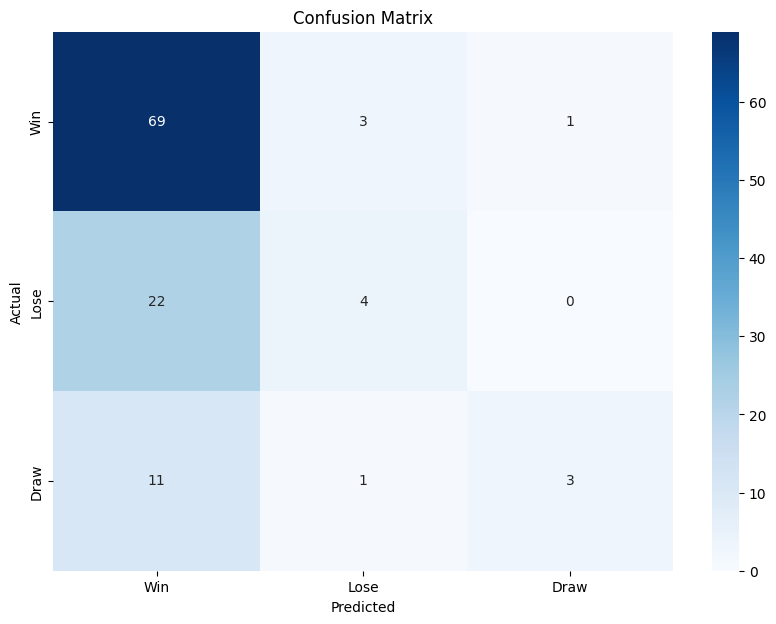

In [617]:
# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]
cm = cm[desired_indices][:, desired_indices]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_labels, yticklabels=desired_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [618]:
results_df = pd.DataFrame(test_df["Predicted"] == test_df["result"], columns=["Correct"])

In [619]:
df_results = pd.read_csv('test_results.csv')

mismatched_df = df_results[df_results['result'] != df_results['Predicted']]

display_df = mismatched_df[["opponent", "result", "Predicted"]]

display_df

,opponent,result,Predicted
0,Brentford,L,W
1,Chelsea,L,W
2,Manchester City,L,W
7,Crystal Palace,D,W
13,Manchester United,L,W
14,Everton,L,W
19,Manchester City,L,W
20,Burnley,D,W
26,Liverpool,L,W
28,Crystal Palace,L,W
